In [40]:
import scanpy as sc
import os
import numpy as np
from tqdm.notebook import tqdm
import glob
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

### This notebook combines the celltyped object with the axes calculated object. It also corrects any mistakes in the analysis so far.

In [41]:
input_folders = glob.glob('D:/amonell/timecourse_final/day*')

In [42]:
output_folder = r'D:/amonell/timecourse_final/analysis/cleaned'
combined_adata = sc.read(os.path.join(output_folder, 'integrated_celltyped.h5ad'))

In [31]:
for input_file in input_folders:
    adata = sc.read(os.path.join(input_file, 'adatas', '07_axes_defined.h5ad'))
    sub_combined = combined_adata[combined_adata.obs['batch'] == os.path.basename(input_file)]
    sub_combined.obs.index = [i.split('-')[0] for i in sub_combined.obs.index.values]
    sub_combined.obs['indices'] = [i for i in range(len(sub_combined.obs.index))]
    indices = adata.obs.merge(sub_combined.obs, left_on='cell', right_index=True, how='left')['indices'].values
    adata = adata[np.where(np.invert(np.isnan(indices)))[0], :]
    
    indices = indices[np.where(np.invert(np.isnan(indices)))]
    indices = indices.astype(int)
    adata.obsm['X_mde'] = sub_combined.obsm['X_mde'][indices, :]
    adata.obsm['X_scVI'] = sub_combined.obsm['X_scVI'][indices, :]
    if 'predicted_longitudinal' not in adata.obs.columns:
        adata.obs['predicted_longitudinal'] = adata.obs['longitudinal']
    adata.obs['batch'] = os.path.basename(input_file)
    adata.write(os.path.join(input_file, 'adatas', '08_final_adata.h5ad'))

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\AppData\Local\Temp\3\ipykernel_53428\44585787.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_combined.obs['indices'] = [i for i in range(len(sub_combined.obs.index))]
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstanc

In [43]:
adatalist = []
for input_file in input_folders:
    adatalist.append(sc.read(os.path.join(input_file, 'adatas', '08_final_adata.h5ad')))

In [44]:
concatenated_all = sc.concat(adatalist)

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### We had an issue with our celltyping file since we have "absoptive" and "absorptive_epithelial" as separate cell types.
##### Fixing those here before writing out the final object

In [45]:
concatenated_all.obs['Type'] = concatenated_all.obs.Type.replace('Absorptive', 'Epithelial_Absorptive')
concatenated_all.obs['Type'] = concatenated_all.obs.Type.replace('Absorptive_Enterocyte', 'Epithelial_Absorptive')
concatenated_all.obs['Type'] = concatenated_all.obs.Type.replace('Secretory', 'Epithelial_Secretory')
concatenated_all.obs['Type'] = concatenated_all.obs.Type.replace('Progenitor', 'Epithelial_Progenitor')
concatenated_all.obs['Type'] = concatenated_all.obs.Type.replace('Secretory_Enterocyte', 'Epithelial_Secretory')
concatenated_all.obs['Subtype'] = concatenated_all.obs.Subtype.replace('Enterocyte_high', 'Enterocyte_1')
concatenated_all.obs['Subtype'] = concatenated_all.obs.Subtype.replace('Enterocyte_med', 'Enterocyte_2')
concatenated_all.obs['Subtype'] = concatenated_all.obs.Subtype.replace('Enterocyte_low', 'Enterocyte_3')

### We also want to clip our epithelial values at 0.6 for visualization

In [46]:
concatenated_all.obs['epithelial_distance_clipped'] = np.clip(concatenated_all.obs['epithelial_distance'].values, 0, 0.6)

### We also have an issue with some of the longitudinal being backwards. We can plot Guca2a expression to find which ones to flip

In [47]:
unique_bat = np.unique(concatenated_all.obs.batch)

In [31]:
import scipy.stats as stats
sc.set_figure_params(dpi=150)
for i in unique_bat:
    longit = concatenated_all[(concatenated_all.obs.batch == i) & concatenated_all.obs.not_removed_from_longitudinal].obs['predicted_longitudinal']
    guca2a = concatenated_all[(concatenated_all.obs.batch == i) & concatenated_all.obs.not_removed_from_longitudinal].X[:, concatenated_all[concatenated_all.obs.batch == i].var.index.isin(['Guca2a'])].flatten()
    print(stats.spearmanr(longit, guca2a), i)
    #sc.pl.embedding(concatenated_all[concatenated_all.obs.batch == i], basis='spatial', color='Guca2a', vmax=1, cmap='Blues', title=i)

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


SignificanceResult(statistic=-0.10702968903987743, pvalue=0.0) day30_SI
SignificanceResult(statistic=0.23520263945782777, pvalue=0.0) day6_SI
SignificanceResult(statistic=-0.26996217140558515, pvalue=0.0) day7_SI_DMSO
SignificanceResult(statistic=0.07169451760653327, pvalue=2.3656643174271026e-246) day7_SI_RARi
SignificanceResult(statistic=0.01752216905566431, pvalue=1.5178096883616423e-19) day8_SI_Ctrl
SignificanceResult(statistic=-0.21725876338619618, pvalue=0.0) day8_SI_Xcr1DTR
SignificanceResult(statistic=-0.22833412329582994, pvalue=0.0) day90_SI


In [48]:
longitude = {'day30_SI': 'outer', 'day6_SI': 'inner', 'day7_SI_DMSO': 'outer', 'day7_SI_RARi': 'inner', 'day8_SI_Ctrl': 'inner', 'day8_SI_Xcr1DTR': 'outer', 'day90_SI': 'outer'}

In [49]:
guca2a_expression = [longitude.get(i) for i in concatenated_all.obs.batch.values]

In [51]:
new_longitudinal = np.zeros(len(concatenated_all.obs))

In [52]:
for i in unique_bat:
    indices = np.where(concatenated_all.obs.batch.values == i)[0]
    if longitude.get(i) == 'outer':
        new_longitudinal[indices] = 1 - concatenated_all[indices, :].obs.predicted_longitudinal.values
    elif longitude.get(i) == 'inner':
        new_longitudinal[indices] = concatenated_all[indices, :].obs.predicted_longitudinal.values

In [53]:
concatenated_all.obs['predicted_longitudinal'] = new_longitudinal

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


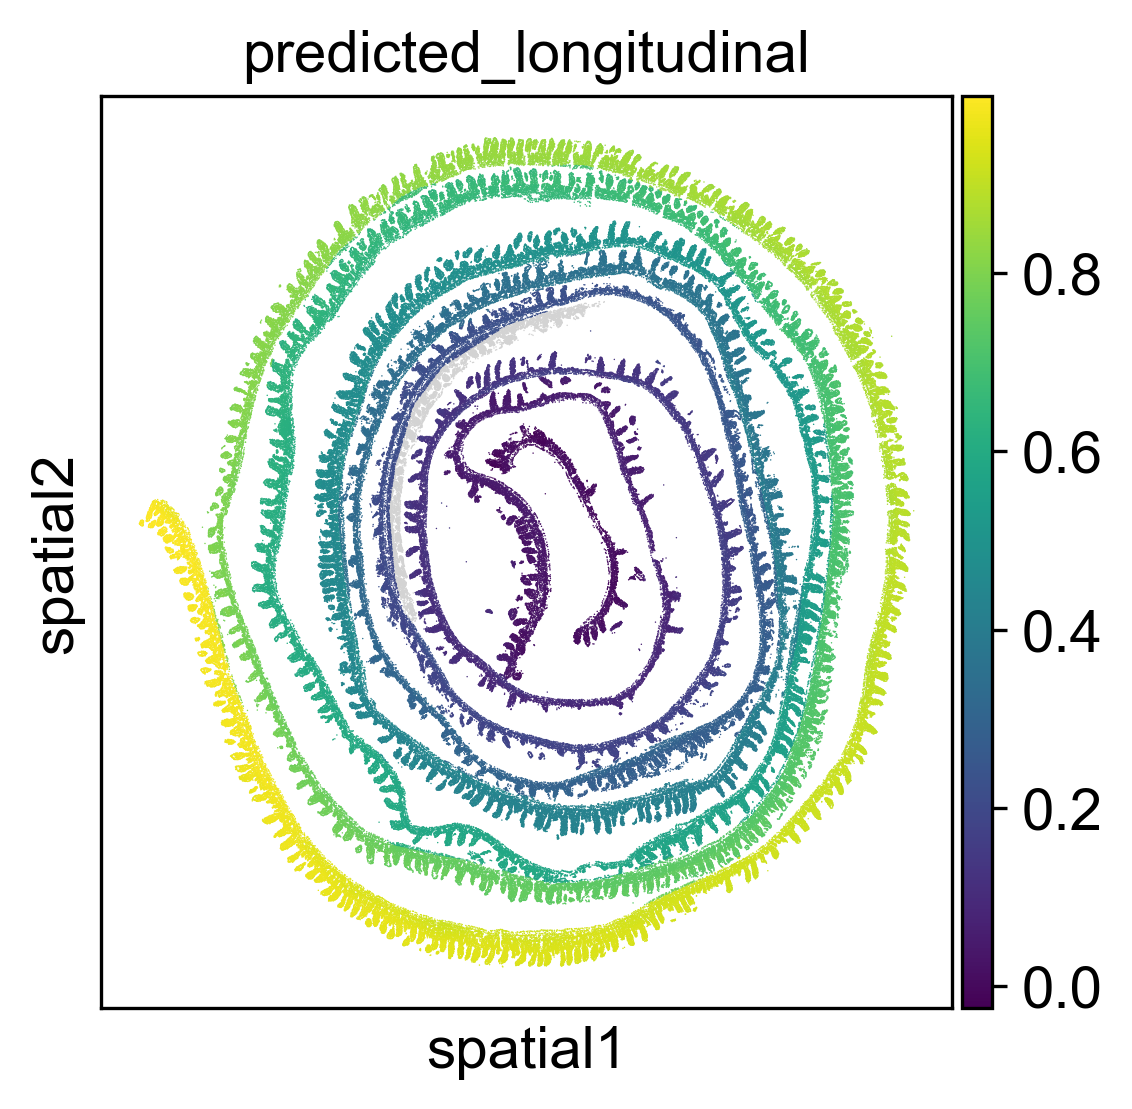

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


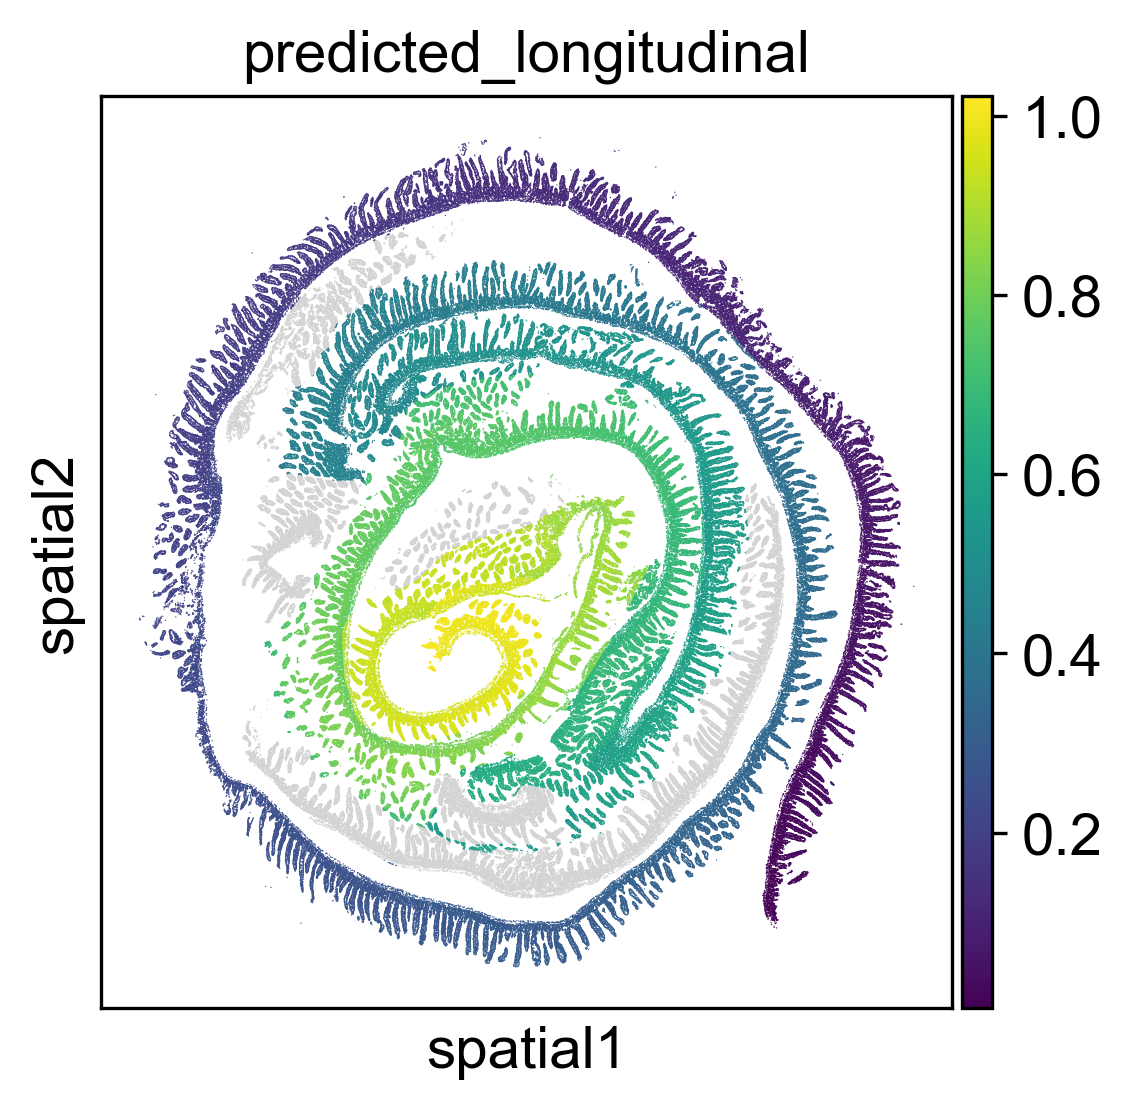

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


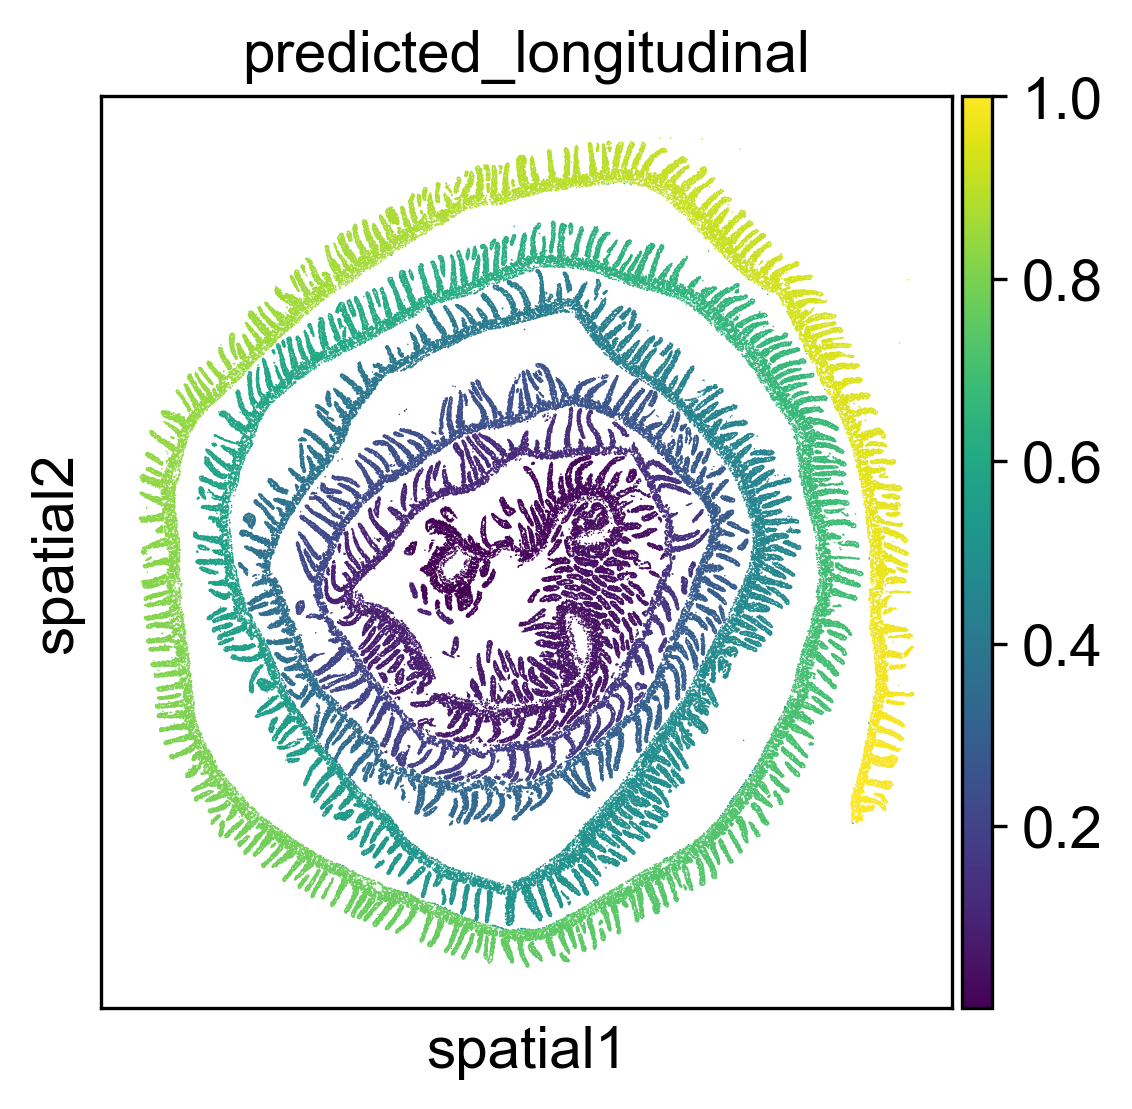

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


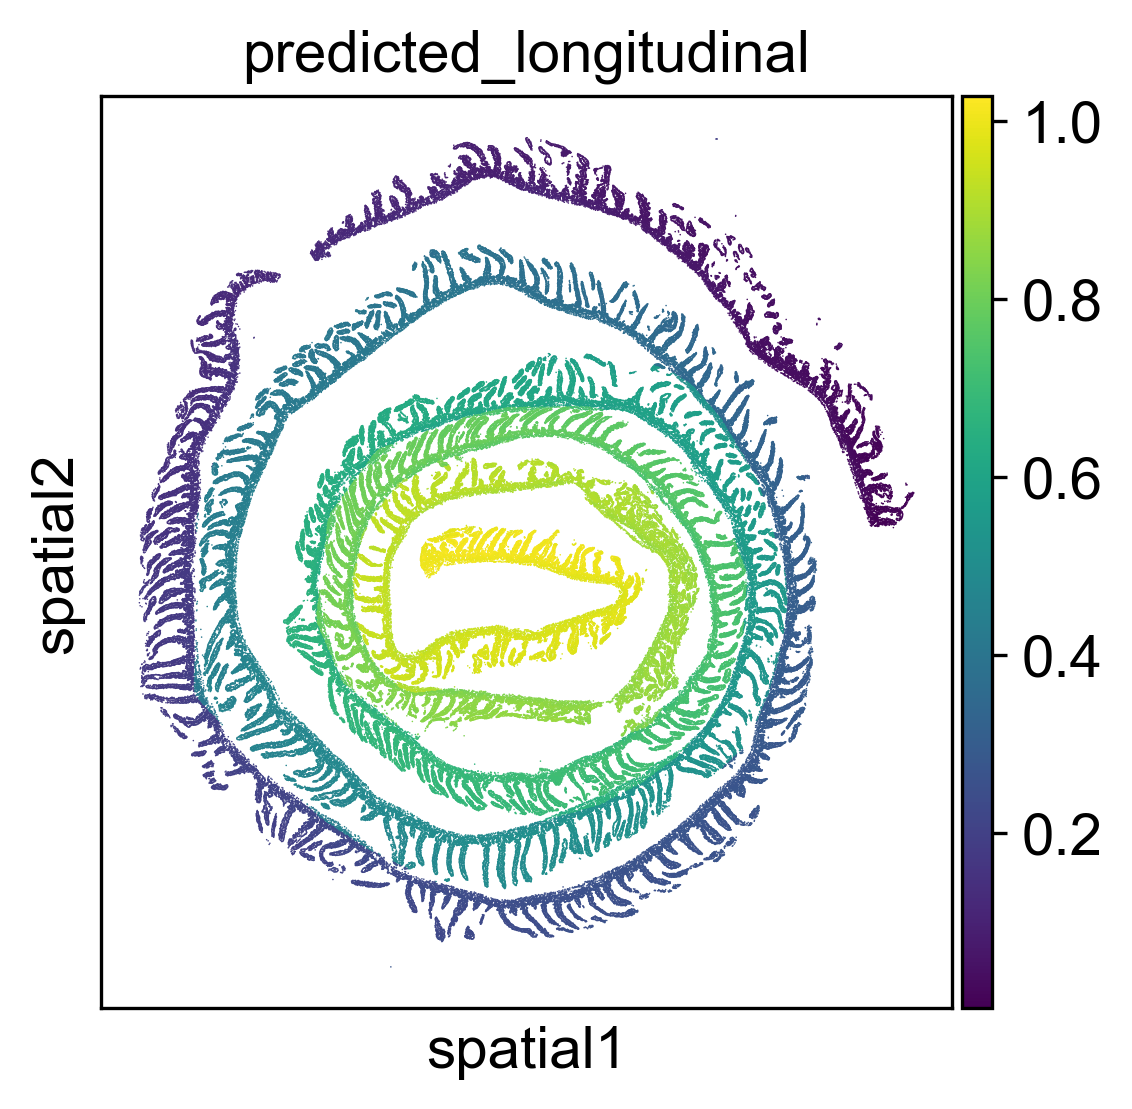

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


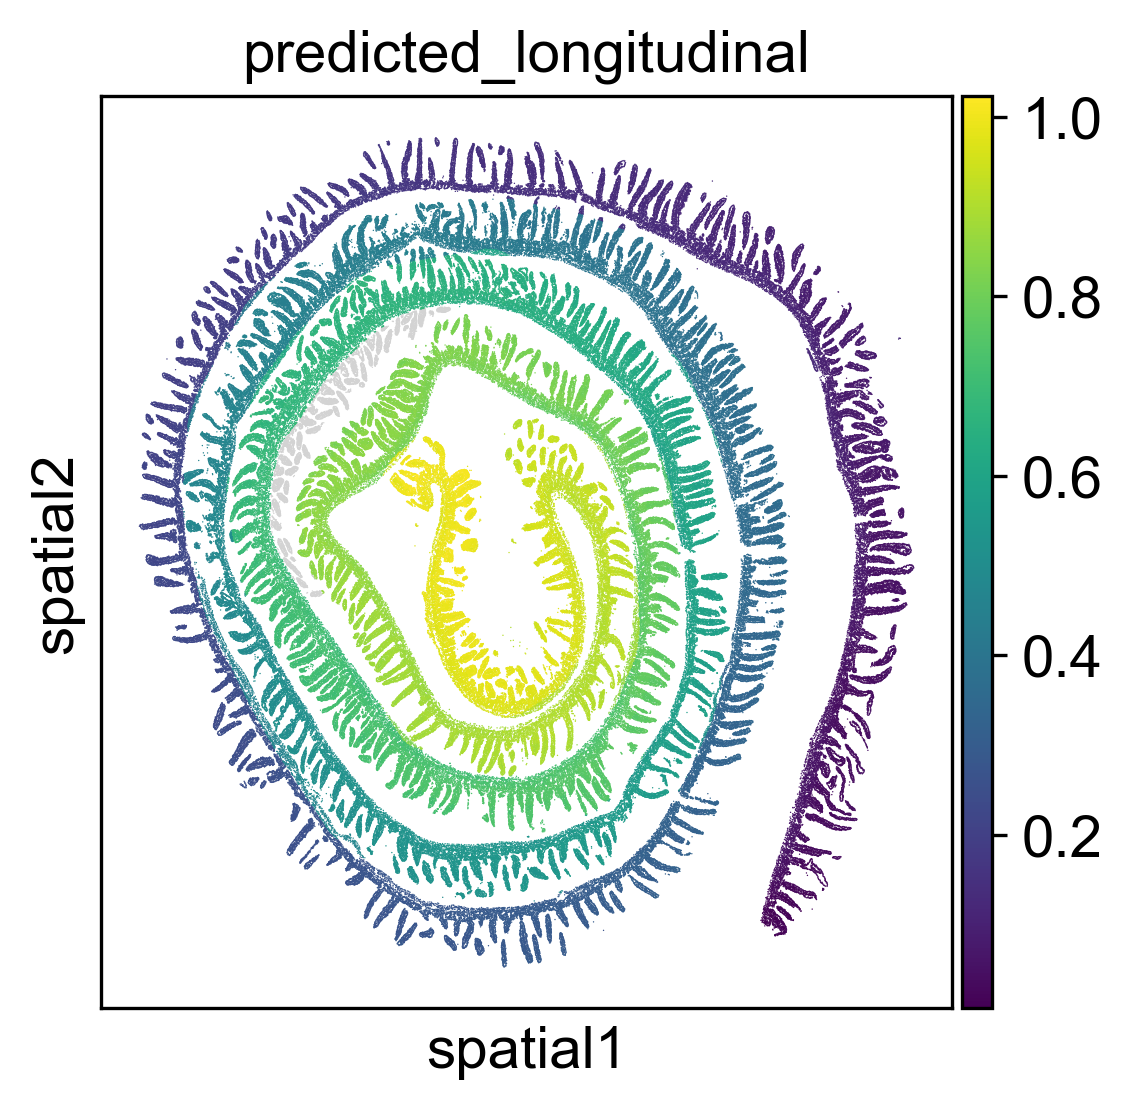

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


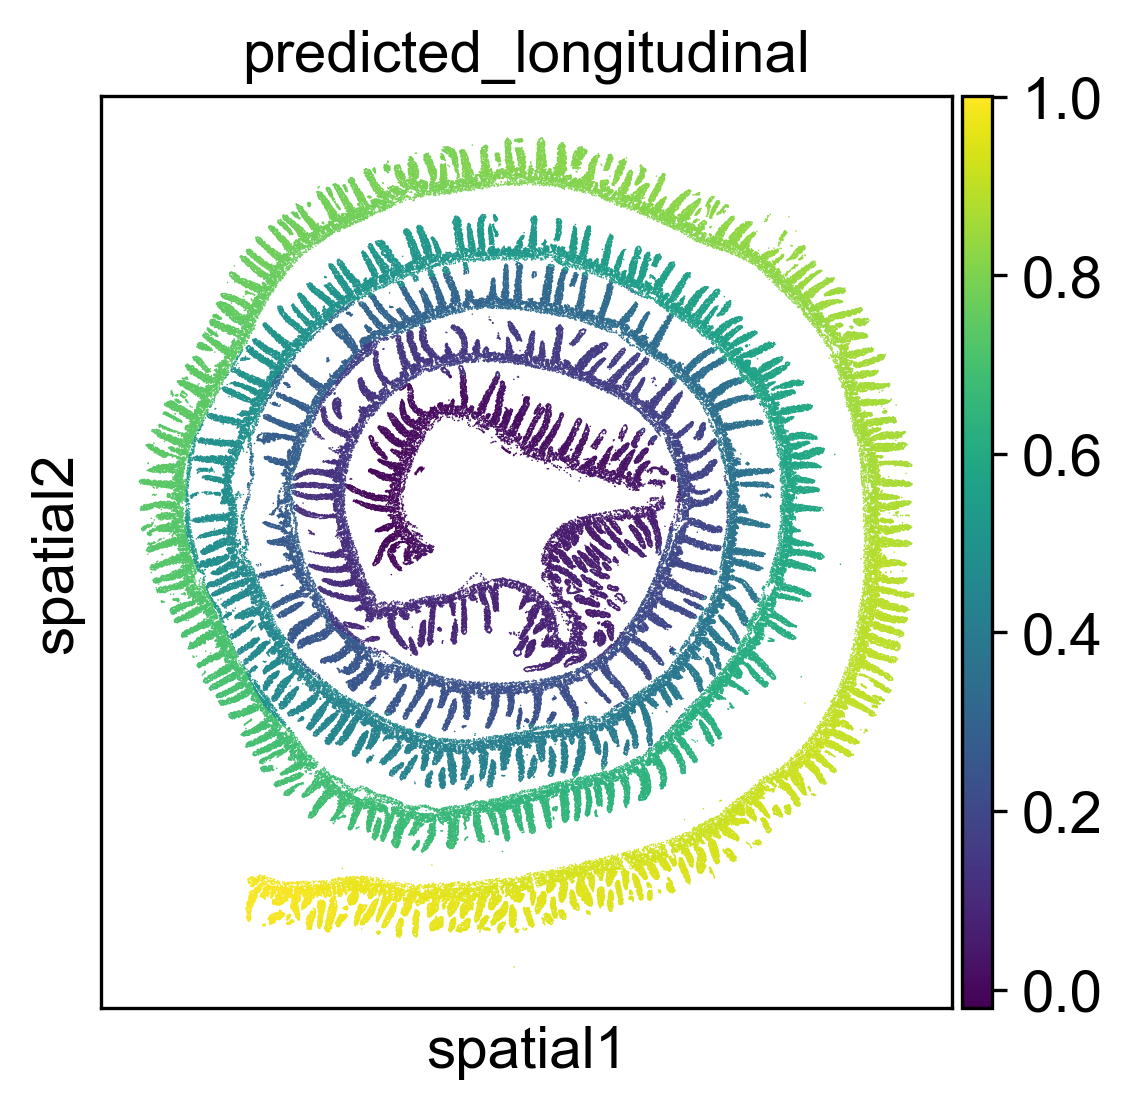

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


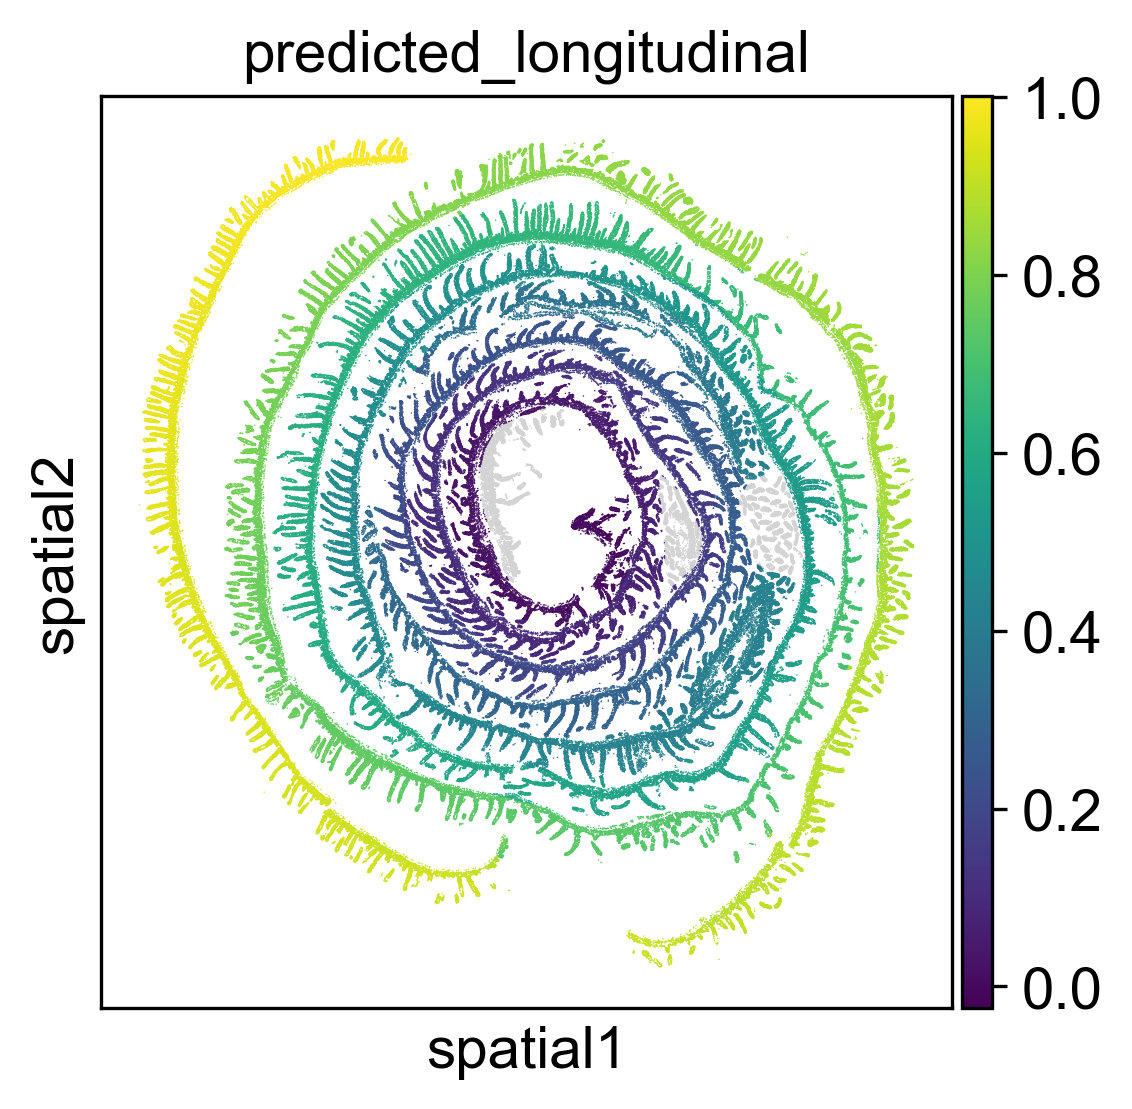

In [54]:
for i in unique_bat:
    sc.pl.embedding(concatenated_all[concatenated_all.obs.batch == i], basis='spatial', color='predicted_longitudinal')

In [55]:
concatenated_all.write(os.path.join(output_folder, 'final_celltyped_and_axes.h5ad'))